# Univariate Systematic Studies

In [12]:
import sys
import localSettings as ls
import os
print(ls.main_path)

C:\Users\Ryan\python-workspace\PeLEE-newmcfilteredsamples\


In [13]:
main_path = ls.main_path
sys.path.append(main_path)

In [14]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 04082020


In [15]:
#########################
# Which type(s?) of study
#########################
#which study?
NUE = False
NUMU = True
PI0 = False
CCmuCPiNoPi0 = False
CCmuNoPi = False
NCNoPi = False
NCcPiNoPi0 = False


#make calculated columns?
NUEVARIABLES = False
NUMUVARIABLES = True

#other globals for notebook
SAVEFIG = False
USECRT = True
USEBDT = False

In [16]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
if USEBDT:
    import xgboost as xgb
    import nue_booster 
    importlib.reload(nue_booster)
import awkward
import pandas as pd

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [17]:
SAMPLE = r'$\nu_e$'
SAMPLEDEF = 'nue'
if (PI0):
    SAMPLE = r"$\pi^0$"
    SAMPLEDEF = 'pi0'
if (NUMU):
    SAMPLE = r'$\nu_{\mu}$'
    SAMPLEDEF = 'numu'
if (CCmuCPiNoPi0):
    SAMPLE = r'$\nu_{\mu}$ CC $\pi$ no $\pi^0$'
    SAMPLEDEF = 'CCmuCPiNoPi0'
if (CCmuNoPi):
    SAMPLE = r'$\nu_{\mu}$ CC no $\pi$'
    SAMPLEDEF = 'CCmuNoPi'
if (NCNoPi):
    SAMPLE = r'$\nu_{\mu}$ NC no $\pi$'
    SAMPLEDEF = 'NCNoPi'
if (NCcPiNoPi0):
    SAMPLE = r'$\nu_{\mu}$ NC $\pi$ no $\pi^0$'
    SAMPLEDEF = 'NCcPiNoPi0'
SAMPLE += ' sample'

In [18]:
variables = [
    "selected", "nu_pdg", 
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "category",
    "topological_score",
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "trk_bkt_purity","hits_ratio", "n_tracks_contained", 
    "crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    "ccnc","flash_pe",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z",
    "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance","proton_e","elec_e",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "run", "sub", "evt", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "contained_fraction",
    
    "weightSpline","weightSplineTimesTune","weightTune",
    
    # truth variables
    "isVtxInFiducial","truthFiducial",
]

if NUE or NUEVARIABLES:
    variables += [
        "shr_dedx_Y", "shr_bkt_pdg","shr_bkt_purity", "p", "pt", "shr_theta",
        "shr_pfp_id_v",
        "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
        "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
        "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",#"shr_energy_tot", 
        "shrmoliereavg","shrmoliererms",
        "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
        "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
        "shr_tkfit_dedx_U", "shr_tkfit_dedx_V",
        "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
        "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
        "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
        "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
        "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    ]
if NUMU or NUMUVARIABLES:
    variables += [
        'trk_mcs_muon_mom_v','trk_range_muon_mom_v','trk_energy_muon',
        'trk_sce_start_x_v','trk_sce_start_y_v','trk_sce_start_z_v',
        'trk_sce_end_x_v','trk_sce_end_y_v','trk_sce_end_z_v',
        'trk_theta_v', 'trk_len_v',
        'pfp_generation_v', 'trk_distance_v'
    ]
    
if PI0 or CCmuCPiNoPi0 or CCmuNoPi or NCcPiNoPi0:
    variables += [
        # pi0 variables
        "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
        "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
        "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
        "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
        "pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z",
        #"pi0_energy2_Y", # pi0 tagger variables
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    ]

# variables to be trained on
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max",
            "trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

BDT_LABELS =  ['pi0','nonpi0']

In [19]:
# Pi0 Selection

# pi0 selection
LOOSE = False
if (LOOSE):
    SCORECUT = 0.8 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  50. # leading photon min energy
    EMIN2 =  20. #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 0.0 # MeV/cm cut on leading shower only
else:
    SCORECUT = 0.5 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  60. # leading photon min energy
    EMIN2 =  40. #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 1.0 # MeV/cm cut on leading shower only

CUT_VAR_V = ["nslice","pi0_shrscore1","pi0_shrscore2","pi0_dot1","pi0_dot2",\
            "pi0_radlen1","pi0_radlen2","pi0_gammadot","pi0_energy1_Y","pi0_energy2_Y",\
            "pi0_dedx1_fit_Y","n_showers_contained"]
CUT_VAL_V = [" == 1"," < %f"%SCORECUT," < %f"%SCORECUT," > %f"%VTXDOT," > %f"%VTXDOT,\
            " > %f"%DVTX," > %f"%DVTX," < %f"%GAMMADOT," > %f"%EMIN1," > %f"%EMIN2,\
            ">= %f"%DEDXCUT," != 0"]

def Pi0Query(APP):

    QUERY = ""
    
    for i,v in enumerate(CUT_VAR_V):
        if (i == 0):
            QUERY  += '%s_%s %s'%(v,APP,CUT_VAL_V[i])
        else:
            QUERY  += ' and %s_%s %s'%(v,APP,CUT_VAL_V[i])   
            
    return QUERY

In [20]:
def NpBoxCutQuery(APP,BDT=False):    
    QUERY = ''   
    # nue preselection
    PRESQ = 'nslice_%s == 1'%APP
    PRESQ += ' and selected_%s == 1'%APP
    PRESQ += ' and shr_energy_tot_cali_%s > 0.07'%APP
    PRESQ += ' and _opfilter_pe_beam_%s > 0 and _opfilter_pe_veto_%s < 20'%(APP,APP)
    
    #return PRESQ
    
    # 1eNp preselection
    NPPRESQ = PRESQ
    NPPRESQ += ' and n_tracks_contained_%s > 0'%APP
    
    return NPPRESQ
    
    # loose box cuts
    NPLCUTQ = NPPRESQ
    NPLCUTQ += ' and CosmicIPAll3D_%s > 10.'%APP
    #NPLCUTQ += ' and trkpid_%s < 0.02'%APP
    NPLCUTQ += ' and hits_ratio_%s > 0.50'%APP
    NPLCUTQ += ' and shrmoliereavg_%s < 9'%APP
    NPLCUTQ += ' and subcluster_%s > 4'%APP
    NPLCUTQ += ' and trkfit_%s < 0.65'%APP
    NPLCUTQ += ' and n_showers_contained_%s == 1'%APP
    NPLCUTQ += ' and tksh_distance_%s < 6.0'%APP
    NPLCUTQ += ' and (shr_tkfit_nhits_tot_%s > 1 and shr_tkfit_dedx_max_%s > 0.5 and shr_tkfit_dedx_max_%s < 5.5)'%(APP,APP,APP)
    NPLCUTQ += ' and secondshower_Y_nhit_%s < 50'%APP
    NPLCUTQ += ' and tksh_angle_%s > -0.9'%APP
    
    return NPLCUTQ
    
    # tight box cuts
    NPTCUTQ = NPLCUTQ
    NPTCUTQ += ' and CosmicIPAll3D_%s > 30.'%APP
    NPTCUTQ += ' and CosmicDirAll3D_%s > -0.98 and CosmicDirAll3D_%s < 0.98'%(APP,APP)
    #NPTCUTQ += ' and trkpid_%s < 0.02'%APP
    NPTCUTQ += ' and hits_ratio_%s > 0.65'%APP
    NPTCUTQ += ' and shr_score_%s < 0.25'%APP
    NPTCUTQ += ' and shrmoliereavg_%s > 2 and shrmoliereavg_%s < 10'%(APP,APP)
    NPTCUTQ += ' and subcluster_%s > 7'%APP
    NPTCUTQ += ' and trkfit_%s < 0.70'%APP
    NPTCUTQ += ' and n_showers_contained_%s == 1'%APP
    NPTCUTQ += ' and tksh_distance_%s < 4.0'%APP
    NPTCUTQ += ' and trkshrhitdist2_%s < 1.5'%APP
    NPTCUTQ += ' and (shr_tkfit_nhits_tot_%s > 1 and shr_tkfit_dedx_max_%s > 1.0 and shr_tkfit_dedx_max_%s < 3.8)'%(APP,APP,APP)
    NPTCUTQ += ' and (secondshower_Y_nhit_%s <= 8 or secondshower_Y_dot_%s <= 0.8 or anglediff_Y_%s <= 40 or secondshower_Y_vtxdist_%s >= 100)'%(APP,APP,APP,APP)
    NPTCUTQ += ' and secondshower_Y_nhit_%s < 30'%APP
    NPTCUTQ += ' and tksh_angle_%s > -0.9 and tksh_angle_%s < 0.70'%(APP,APP)
    
    # BDT cuts
    # 0304 extnumi, pi0 and nonpi0
    if (BDT):
        BDTCQ = NPLCUTQ
        BDTCQ += ' and pi0_score_%s > 0.67 and nonpi0_score_%s > 0.70'%(APP,APP)
        return BDTCQ
    
    return NPTCUTQ

#### NUMU Constraint

In [21]:
####################################
# Cuts for NUMU constraint selection
####################################
# returns QUERY, track_cuts for given appendix ('CV' OR 'VAR')
#updated for SCE
#will swap numerical vals at end
FVx = [10,246]#[5,251]
FVy = [-110,110]
FVz = [20,986]

def NUMUQuery(APPEND,verbose=False):
    query = 'nslice_{} == 1'.format(APPEND)
    query += ' and topological_score_{} > 0.06'.format(APPEND)
    query += ' and reco_nu_vtx_sce_x_{} > FVx[0] and reco_nu_vtx_sce_x_{} < FVx[1]'.format(APPEND,APPEND)
    query += ' and reco_nu_vtx_sce_y_{} > FVy[0] and reco_nu_vtx_sce_y_{} < FVy[1]'.format(APPEND,APPEND)
    query += ' and reco_nu_vtx_sce_z_{} > FVz[0] and reco_nu_vtx_sce_z_{} < FVz[1]'.format(APPEND,APPEND)
    query += ' and ( (reco_nu_vtx_sce_z_{} < 675) or (reco_nu_vtx_sce_z_{} > 775) )'.format(APPEND,APPEND) #avoid dead wire region    
    if USECRT: query += ' and (crtveto_{}!=1 or crthitpe_{} < 100.) and (_closestNuCosmicDist_{} > 20.)'.format(APPEND,APPEND,APPEND)

    query = query.replace('FVx[0]',str(FVx[0]))
    query = query.replace('FVy[0]',str(FVy[0]))
    query = query.replace('FVz[0]',str(FVz[0]))
    query = query.replace('FVx[1]',str(FVx[1]))
    query = query.replace('FVy[1]',str(FVy[1]))
    query = query.replace('FVz[1]',str(FVz[1])) 

    if verbose: print ("QUERY: \n",query)

    track_cuts = [
        ('trk_sce_start_x_v_{}'.format(APPEND), '>', FVx[0]),
        ('trk_sce_start_x_v_{}'.format(APPEND), '<', FVx[1]),
        ('trk_sce_start_y_v_{}'.format(APPEND), '>', FVy[0]),
        ('trk_sce_start_y_v_{}'.format(APPEND), '<', FVy[1]),
        ('trk_sce_start_z_v_{}'.format(APPEND), '>', FVz[0]),
        ('trk_sce_start_z_v_{}'.format(APPEND), '<', FVz[1]),
        ('trk_sce_end_x_v_{}'.format(APPEND), '>', FVx[0]),
        ('trk_sce_end_x_v_{}'.format(APPEND), '<', FVx[1]),
        ('trk_sce_end_y_v_{}'.format(APPEND), '>', FVy[0]),
        ('trk_sce_end_y_v_{}'.format(APPEND), '<', FVy[1]),
        ('trk_sce_end_z_v_{}'.format(APPEND), '>', FVz[0]),
        ('trk_sce_end_z_v_{}'.format(APPEND), '<', FVz[1]),
        ('trk_p_quality_v_{}'.format(APPEND), '>', -0.5),
        ('trk_p_quality_v_{}'.format(APPEND), '<', 0.5),
        ('trk_llr_pid_score_v_{}'.format(APPEND), '>', 0.2),
        ('trk_score_v_{}'.format(APPEND), '>', 0.8),
        ('trk_len_v_{}'.format(APPEND), '>', 10),
        ('pfp_generation_v_{}'.format(APPEND), '==', 2),
        ('trk_distance_v_{}'.format(APPEND), '<', 4)
    ]

    if verbose: 
        print("\ntrack cuts:")
        cut_string = ""
        for c,cut in enumerate(track_cuts):
            if c > 0: cut_string += " and "
            if type(cut[1]) == list: cut_string += "( ({} {} {}) or ({} {} {}) )".format(cut[0],cut[1][0],cut[2][0],cut[0],cut[1][1],cut[2][1])
            else: cut_string += "{} {} {}".format(cut[0],cut[1],cut[2])
        print(cut_string)
    
    return query, track_cuts

## Load DataFrames and make Calculated Columns
#### Uproot

In [22]:
importlib.reload(ls)
##################################################
# Declare which dataframes to load and load uproot file
# This is dependent on the state variables above
##################################################
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

if (NUE):
    # for TPC variations
    NUECV = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    
    NUEWX = "prodgenie_bnb_nue_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    NUEWYZ = "prodgenie_bnb_nue_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    NUESCE = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_SCE_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    NUEWAYZ = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    NUEWAXZ = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleXZ_v08_00_00_38_run3b_reco2_reco2.root"
    NUER2   = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_Recomb2_reco2_v08_00_00_39_run3b_reco2_reco2.root"
    NUEdEdx = "prodgenie_bnb_nue_overlay_DetVar_wiremod_ScaledEdX_v08_00_00_39_run3b_reco2_reco2.root"
    
    DETVAR_N_V = ["WireMod X", "WireMod YZ", 'SCE','WireMod angle YZ', "WireMod Angle XZ","Recomb","WireMod dEdx"]
    DETVAR_S_V = [NUEWX,NUEWYZ,NUESCE,NUEWAYZ,NUEWAXZ,NUER2,NUEdEdx]
    
    # for LY variations
    #NUECV = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run1_reco2_reco2.root"
    #NUELY = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_LYDown_v08_00_00_37_run1_reco2_reco2.root"
    #NUERY = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_LYRayleigh_v08_00_00_37_run1_reco2_reco2.root"
    
    #DETVAR_N_V = ["LY Down", "Rayleigh"]
    #DETVAR_S_V = [NUELY,NUERY]
    
    CV = uproot.open(ls.ntuple_path+NUECV)[fold][tree]
    #CVPOTSUB   = uproot.open(ls.main_path+NUECV)[fold]["SubRun"]
    

if (PI0):
    
    PI0CV  = "prodgenie_cc_pi0_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    PI0WX  = "prodgenie_cc_pi0_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    PI0WYZ = "prodgenie_cc_pi0_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    PI0AXZ = "prodgenie_data_cc_pi0_overlay_DetVar_WireModAngleXZ_v08_00_00_38_run3b_reco2_reco2.root"
    PI0AYZ = "prodgenie_data_cc_pi0_overlay_DetVar_WireModAngleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    
    DETVAR_N_V = ["WireMod X","WireMod YZ","WireMod angle XZ","WireMod angle YZ"]
    DETVAR_S_V = [PI0WX,PI0WYZ,PI0AXZ,PI0AYZ]
    
    CV = uproot.open(ls.ntuple_path+PI0CV)[fold][tree]
    
if (NUMU):
    NUMUCV = "prodgenie_bnb_nu_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    
    NUMULYATT = "prodgenie_bnb_nu_overlay_DetVar_LYAttenuation_v08_00_00_38_run3b_reco2_reco2.root"
    NUMULYDOWN = "prodgenie_bnb_nu_overlay_DetVar_LYDown_v08_00_00_37_v2_run3b_reco2_reco2.root"
    NUMURY = "prodgenie_bnb_nu_overlay_DetVar_LYRayleigh_v08_00_00_37_run3b_reco2_reco2.root"
    NUMUSCE = "prodgenie_bnb_nu_overlay_DetVar_SCE_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    NUMUWX = "prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    NUMUWYZ = "prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    NUMUWAXZ = "prodgenie_bnb_nu_overlay_DetVar_WireModAngleXZ_v08_00_00_38_exe_run3b_reco2_reco2.root"
    NUMUWAYZ = "prodgenie_bnb_nu_overlay_DetVar_WireModAngleYZ_v08_00_00_38_exe_run3b_reco2_reco2.root"
    NUMUWDEDX = "prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaledEdX_v08_00_00_39_run3b_reco2_reco2.root"
    NUMURECOMB = "prodgenie_bnb_nu_overlay_DetVar_Recomb2_reco2_v08_00_00_39_run3b_reco2_reco2.root"

    DETVAR_N_V = ['LY Attenuation','LY Down','Rayleigh','SCE',
                  'WireMod X','WireMod YZ',
                  'WireMod Angle XZ','WireMod Angle YZ',
                 'WireMod dEdX', 'Recomb']

    DETVAR_S_V = [NUMULYATT,NUMULYDOWN, NUMURY, NUMUSCE,
                  NUMUWX, NUMUWYZ,
                  NUMUWAXZ, NUMUWAYZ,
                 NUMUWDEDX,NUMURECOMB]
    
    CV = uproot.open(ls.ntuple_path+NUMUCV)[fold][tree]
    
if (CCmuCPiNoPi0):
    
    CVF = "prodgenie_filter_CCmuCPiNoPi0_overlay_mcc9_v08_00_00_33_run3_reco2_reco2.root"
    CV = uproot.open(ls.ntuple_path+CVF)[fold][tree]
    
    VX = "prodgenie_CCmuCPiNoPi0_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    VYZ = "prodgenie_CCmuCPiNoPi0_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    
    DETVAR_N_V = ["WireMod X","WireMod YZ"]
    DETVAR_S_V = [VX,VYZ]
    
if (CCmuNoPi):
    
    CVF = "prodgenie_tight_filter_CCmuNoPi_mcc9_v08_00_00_35_run3_reco2_reco2.root"
    CV = uproot.open(ls.ntuple_path+CVF)[fold][tree]
    
    VX = "prodgenie_CCmuNoPi_tight_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    VYZ = "prodgenie_CCmuNoPi_tight_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"

    DETVAR_N_V = ["WireMod X","WireMod YZ"]
    DETVAR_S_V = [VX,VYZ]
    
if (NCNoPi):
    
    CVF = "prodgenie_tight_filter_NCNoPi_mcc9_v08_00_00_35_run3_reco2_reco2.root"
    CV = uproot.open(ls.ntuple_path+CVF)[fold][tree]
    
    VX = "prodgenie_NCNoPi_tight_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    VYZ = "prodgenie_NCNoPi_tight_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"

    DETVAR_N_V = ["WireMod X","WireMod YZ"]
    DETVAR_S_V = [VX,VYZ]
        
if (NCcPiNoPi0):
    
    CVF = "prodgenie_NCcPiNoPi0_overlay_mcc9_v08_00_00_33_New_run3_reco2_reco2.root"
    CV = uproot.open(ls.ntuple_path+CVF)[fold][tree]
    
    VX = "prodgenie_NCcPiNoPi0_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    VYZ = "prodgenie_NCcPiNoPi0_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"

    DETVAR_N_V = ["WireMod X","WireMod YZ"]
    DETVAR_S_V = [VX,VYZ]

#### DataFrame Building

In [23]:
importlib.reload(ls)
    
###############################
# Central Value DF
CVDF  = CV.pandas.df(variables, flatten=False)

#CVPOTDF = CV.pandas.df(['run','sub'],flatten=False)
#CVPOTSUBDF = CVPOTSUB.pandas.df(['run','subRun','pot'],flatten=False)
#CVPOTSUBDF = CVPOTSUBDF.rename(columns={"subRun": "sub","run":"run"})

CVDF['identifier'] = CVDF['run']*100000 + CVDF['evt'] #to line up events with sample events

CVDF.loc[ CVDF['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ CVDF['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ CVDF['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ np.isnan(CVDF['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

# if running selections, define all necessary variables
if (NUEVARIABLES):
    INTERCEPT = 0.0
    SLOPE = 0.83
    trk_llr_pid_v = CV.array('trk_llr_pid_score_v')
    trk_energy_proton_v = CV.array('trk_energy_proton_v')
    trk_calo_energy_y_v = CV.array('trk_calo_energy_y_v')
    trk_id = CV.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    CVDF['trkpid'] = trk_llr_pid_v_sel
    CVDF['protonenergy'] = trk_energy_proton_sel
    CVDF['trackcaloenergy'] = trk_calo_energy_y_sel
    CVDF['subcluster'] = CVDF['shrsubclusters0'] + CVDF['shrsubclusters1'] + CVDF['shrsubclusters2']
    CVDF['trkfit'] = CVDF['shr_tkfit_npointsvalid'] / CVDF['shr_tkfit_npoints']
    CVDF['anglediff_Y'] = np.abs(CVDF['secondshower_Y_dir']-CVDF['shrclusdir2'])
    CVDF['shr_tkfit_nhits_tot'] = (CVDF['shr_tkfit_nhits_Y']+CVDF['shr_tkfit_nhits_U']+CVDF['shr_tkfit_nhits_V'])
    CVDF.loc[:,'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_Y']
    CVDF.loc[(CVDF['shr_tkfit_nhits_U']>CVDF['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_U']
    CVDF.loc[(CVDF['shr_tkfit_nhits_V']>CVDF['shr_tkfit_nhits_Y']) & (CVDF['shr_tkfit_nhits_V']>CVDF['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_V']
    CVDF["reco_e"] = (CVDF["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + CVDF["trk_energy_tot"] 
    CVDF["is_signal"] = CVDF["category"] == 11

    if (USEBDT == True):
        for label, bkg_query in zip(BDT_LABELS, nue_booster.bkg_queries):
            with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
                booster = pickle.load(booster_file)
                CVDF[label+"_score"] = booster.predict(
                    xgb.DMatrix(CVDF[TRAINVAR]),
                    ntree_limit=booster.best_iteration)

if (NUMUVARIABLES):
    M_mu = 0.105 #GeV/c
    CVDF['trk_p_quality_v'] = (CVDF['trk_mcs_muon_mom_v']-CVDF['trk_range_muon_mom_v'])/CVDF['trk_range_muon_mom_v']
    CVDF['trk_costheta_v'] = CVDF['trk_theta_v'].apply(lambda x: np.cos(x))
    CVDF['reco_nu_e_range'] = CVDF["trk_energy_muon"] + (CVDF["trk_energy_tot"] - CVDF["trk_energy"]) + M_mu
    CVDF['reco_muon_e_range'] = CVDF["trk_energy_muon"] + M_mu

print ('there are %i CV events'%(CVDF.shape[0]))

DETSYS_SAMPLE_V = [] #list of merged CV-VAR dfataframes
POT_V = [] #POT of samples? Not really used elsewhere

for i,N in enumerate(DETVAR_N_V):
    
    VAR = uproot.open(ls.ntuple_path+DETVAR_S_V[i])[fold][tree]
    VARCVDF = VAR.pandas.df(variables, flatten=False)
    
    #VARPOTDF = VAR.pandas.df(['run','sub'],flatten=False)
    
    # intersect VARPOTDF and CVPOTDF to get appropriate POT
    #INTPOT = pd.merge(CVPOTDF,VARPOTDF,how='inner',on=['run','sub'])
    #print (INTPOT)
    
    #VARPOTSUB   = uproot.open(ls.ntuple_path+DETVAR_S_V[i])[fold]["SubRun"]
    #VARPOTSUBDF = VARPOTSUB.pandas.df(['run','subRun','pot'],flatten=False)
    #VARPOTSUBDF = VARPOTSUBDF.rename(columns={"subRun": "sub","run":"run"})
    
    #POTSUM = np.sum(VARPOTSUBCVDF['pot'].values)
    #print ('POT sum before merge is ',POTSUM)
    
    #INTPOTSUBDF = pd.merge(CVPOTSUBDF,VARPOTSUBDF,how='inner',on=['run','sub'],suffixes=('_DF','_POT'))
    #print (INTPOTSUBDF)
    
    #POTSUM = np.sum(INTPOTSUBCVDF['pot_POT'].values)/2.
    #print ('POT sum after merge is ',POTSUM)
    
    POT_V.append(6e22)
    
    VARCVDF['identifier'] = VARCVDF['run']*100000 + VARCVDF['evt']
    
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ np.isnan(VARCVDF['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

    # if running nue selections, define all necessary variables
    if (NUEVARIABLES):
        INTERCEPT = 0.0
        SLOPE = 0.83
        trk_llr_pid_v = VAR.array('trk_llr_pid_score_v')
        trk_energy_proton_v = VAR.array('trk_energy_proton_v')
        trk_calo_energy_y_v = VAR.array('trk_calo_energy_y_v')
        trk_id = VAR.array('trk_id')-1 # I think we need this -1 to get the right result
        trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
        trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
        trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
        VARCVDF['trkpid'] = trk_llr_pid_v_sel
        VARCVDF['protonenergy'] = trk_energy_proton_sel
        VARCVDF['trackcaloenergy'] = trk_calo_energy_y_sel
        VARCVDF['subcluster'] = VARCVDF['shrsubclusters0'] + VARCVDF['shrsubclusters1'] + VARCVDF['shrsubclusters2']
        VARCVDF['trkfit'] = VARCVDF['shr_tkfit_npointsvalid'] / VARCVDF['shr_tkfit_npoints']
        VARCVDF['anglediff_Y'] = np.abs(VARCVDF['secondshower_Y_dir']-VARCVDF['shrclusdir2'])
        VARCVDF['shr_tkfit_nhits_tot'] = (VARCVDF['shr_tkfit_nhits_Y']+VARCVDF['shr_tkfit_nhits_U']+VARCVDF['shr_tkfit_nhits_V'])
        VARCVDF.loc[:,'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_Y']
        VARCVDF.loc[(VARCVDF['shr_tkfit_nhits_U']>VARCVDF['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_U']
        VARCVDF.loc[(VARCVDF['shr_tkfit_nhits_V']>VARCVDF['shr_tkfit_nhits_Y']) & (VARCVDF['shr_tkfit_nhits_V']>VARCVDF['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_V']
        VARCVDF["reco_e"] = (VARCVDF["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + VARCVDF["trk_energy_tot"]   
        VARCVDF["is_signal"] = VARCVDF["category"] == 11 
    
        if (USEBDT == True):
            for label, bkg_query in zip(BDT_LABELS, nue_booster.bkg_queries):
                with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
                    booster = pickle.load(booster_file)
                    VARCVDF[label+"_score"] = booster.predict(
                        xgb.DMatrix(VARCVDF[TRAINVAR]),
                        ntree_limit=booster.best_iteration)
    
    if (NUMUVARIABLES):
        VARCVDF['trk_p_quality_v'] = (VARCVDF['trk_mcs_muon_mom_v']-VARCVDF['trk_range_muon_mom_v'])/VARCVDF['trk_range_muon_mom_v']
        VARCVDF['trk_costheta_v'] = VARCVDF['trk_theta_v'].apply(lambda x: np.cos(x))
        VARCVDF['reco_nu_e_range'] = VARCVDF["trk_energy_muon"] + (VARCVDF["trk_energy_tot"] - VARCVDF["trk_energy"]) + M_mu
        VARCVDF['reco_muon_e_range'] = VARCVDF["trk_energy_muon"] + M_mu
                                     
    INT = pd.merge(CVDF, VARCVDF, how='inner', on=['identifier'],suffixes=('_CV', '_VAR'))

    
    print ('intersection for %15s variation has %i events'%(N,INT.shape[0]))
    DETSYS_SAMPLE_V.append(INT)
    
    #break

there are 88344 CV events
intersection for  LY Attenuation variation has 87763 events
intersection for         LY Down variation has 86964 events
intersection for        Rayleigh variation has 88344 events
intersection for             SCE variation has 81646 events
intersection for       WireMod X variation has 87833 events
intersection for      WireMod YZ variation has 87775 events
intersection for WireMod Angle XZ variation has 88267 events
intersection for WireMod Angle YZ variation has 87911 events
intersection for    WireMod dEdX variation has 69559 events
intersection for          Recomb variation has 71389 events


## Functions for this notebook
These are here instead of the plotter.py due to the odd way in which the variables need to be defined with the "_CV" or "_VAR" appendices

In [24]:
####################################################
#all the code necessary to make the track-level cuts
###################################################
def _apply_track_cuts(df,variable,track_cuts,mask,verbose=False):
    """
    returns array with track-level cuts applied
    
    need to do this fancy business with the apply function to make masks
    """
    for (var,op,val) in track_cuts:
        if type(op) == list:
            #this means treat two conditions in an 'or' fashion
            or_mask1 = df[var].apply(lambda x: eval("x{}{}".format(op[0],val[0])))#or condition 1
            or_mask2 = df[var].apply(lambda x: eval("x{}{}".format(op[1],val[1])))#or condition 2
            mask *= (or_mask1 + or_mask2) #just add the booleans
        else:
            mask *= df[var].apply(lambda x: eval("x{}{}".format(op,val))) #layer on each cut mask
    VARS = (df[variable]*mask).apply(lambda x: x[x != False]) #apply mask
    if verbose: print("before cleaning: \n{}".format(VARS))
    VARS = VARS[VARS.apply(lambda x: len(x) > 0)] #clean up empty slices
    #fix list comprehension issue for non '_v' variables
    if "_v_" not in variable:
        VARS = VARS.apply(lambda x: x[0])
        
    if verbose:
        print(variable)
        print("before mask: {}".format(df[variable]))
        print("after mask: {}".format(VARS))
        try:
            print("masking ", VARS[VARS.apply(lambda x: len(x) <= 0)])
        except:
            print("not masking")

    return VARS, mask

def _select_longest(df, VARS, mask):
    if "_CV" in VARS.name:
        trk_lens = (df['trk_len_v_CV']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    elif "_VAR" in VARS.name:
        trk_lens = (df['trk_len_v_VAR']*mask).apply(lambda x: x[x != False])#apply mask to track lengths
    else:
        raise ValueError("Improper name of VARS: {}".format(VARS.name))
    trk_lens = trk_lens[trk_lens.apply(lambda x: len(x) > 0)]#clean up empty slices
    longest_mask = trk_lens.apply(lambda x: x == x[list(x).index(max(x))])#identify longest
    VARS = (VARS*longest_mask).apply(lambda x: x[x!=False])#apply mask
    VARS = VARS[VARS.apply(lambda x: len(x) > 0)]#clean up empty slices
    if len(VARS.iloc[0]) == 1:
        VARS = VARS.apply(lambda x: x[0] if len(x)>0 else -999)#expect values, not lists, for each event
    else:
        raise ValueError(
        "There are more than one longest track per slice")

    return VARS, longest_mask

def _selection(variable, sample, query="selected==1", extra_cut='', 
               track_cuts=None, select_longest=True,verbose=False):
    """
    variable: string, about which info to be returned
    sample: dataframe, to be queried
    query: string, event-level queries
    extra_cut: string, just another cut in addition to query
    select_longest: bool, will select longest track in each slice after cuts
        should be on when variable is track-level
    fix: string, should be "_CV" or "_VAR"
        on which sample to apply the cuts
    return_fix: string, should be "_CV" or "_VAR"
        which sample to return
    
    Returns an array of track/event variables that pass cuts
    """
    query += extra_cut
        
    df = sample.copy().query(query)
    #start dealing with the track variables
    track_cuts_mask = df[variable].apply(lambda x: x == x) #all-True mask
    if track_cuts is not None:
        VARS, track_cuts_mask = _apply_track_cuts(df,variable,track_cuts,track_cuts_mask,verbose=verbose)#VARS is cleaned of empty frames
    else:
        VARS = df[variable]#VARS is not clean of empty frames

    if "_v_" in variable and select_longest:
        VARS, longest_mask = _select_longest(df, VARS, track_cuts_mask)
    
    return VARS

In [25]:
def COVARIANCE(n_cv,n_var):
    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n_var[i] - n_cv[i])*(n_var[j] - n_cv[j])

    frac_cov = np.empty([len(n_cv), len(n_cv)])
    corr = np.empty([len(n_cv), len(n_cv)])

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            frac_cov[i][j] =  cov[i][j] / (n_cv[i] * n_cv[j])
            corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])
    return cov,frac_cov,corr

In [26]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [27]:
def SliceQuery(APP):
    return 'nslice_%s == 1'%APP

# Studies

In [28]:
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

#plt.rcParams.update({'font.size': 14})


nslice_CV == 1 and topological_score_CV > 0.06 and reco_nu_vtx_sce_x_CV > 10 and reco_nu_vtx_sce_x_CV < 246 and reco_nu_vtx_sce_y_CV > -110 and reco_nu_vtx_sce_y_CV < 110 and reco_nu_vtx_sce_z_CV > 20 and reco_nu_vtx_sce_z_CV < 986 and ( (reco_nu_vtx_sce_z_CV < 675) or (reco_nu_vtx_sce_z_CV > 775) ) and (crtveto_CV!=1 or crthitpe_CV < 100.) and (_closestNuCosmicDist_CV > 20.) nslice_VAR == 1 and topological_score_VAR > 0.06 and reco_nu_vtx_sce_x_VAR > 10 and reco_nu_vtx_sce_x_VAR < 246 and reco_nu_vtx_sce_y_VAR > -110 and reco_nu_vtx_sce_y_VAR < 110 and reco_nu_vtx_sce_z_VAR > 20 and reco_nu_vtx_sce_z_VAR < 986 and ( (reco_nu_vtx_sce_z_VAR < 675) or (reco_nu_vtx_sce_z_VAR > 775) ) and (crtveto_VAR!=1 or crthitpe_VAR < 100.) and (_closestNuCosmicDist_VAR > 20.)
None None
starting LY Attenuation...


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


starting LY Down...
starting Rayleigh...
starting SCE...
starting WireMod X...
starting WireMod YZ...
starting WireMod Angle XZ...
starting WireMod Angle YZ...
starting WireMod dEdX...
starting Recomb...


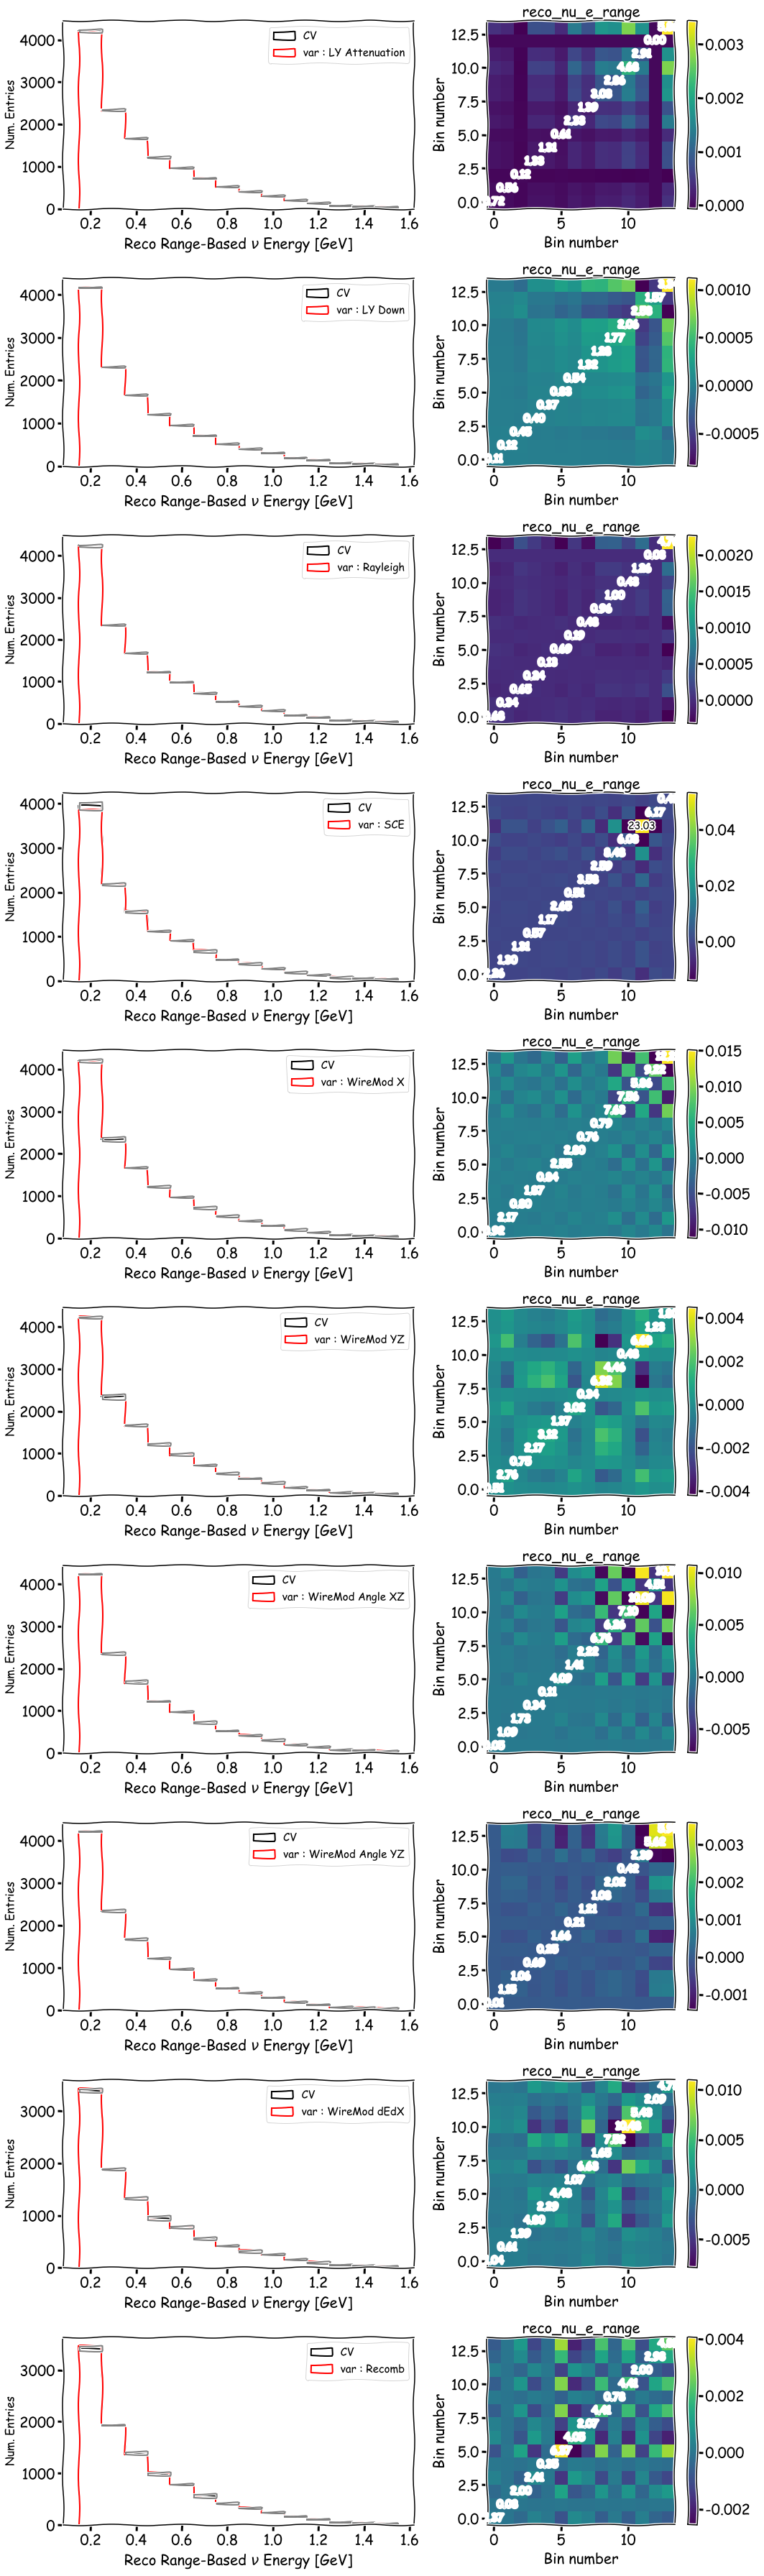

In [31]:
#################################
# Make sheet-o-plots
# Hist_LYA | frac_cov_LYA
# Hist_SCE | frac_cov_SCE
# ...
##################################
importlib.reload(ls)

#potentially useful values
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]
M_mu = 0.105 #GeV/c

#choose what you want to show
VARIABLE = 'reco_nu_e_range'
TITLE = r'Reco Range-Based $\nu$ Energy [GeV]'
BINEDGES = np.linspace(0.15,1.55,15)

QUERY_CV, track_cuts_CV = NUMUQuery("CV")
QUERY_VAR, track_cuts_VAR = NUMUQuery("VAR")
#QUERY_CV, track_cuts_CV = 'nslice_CV == 1', None
#QUERY_VAR, track_cuts_VAR = 'nslice_VAR == 1', None
track_cuts_CV = None
track_cuts_VAR = None
print(QUERY_CV,QUERY_VAR)
print(track_cuts_CV,track_cuts_VAR)

SAVEFIG = True
tag = "presel_xkcd"

#fig = plt.figure(figsize=(20,3*len(DETVAR_N_V)))
with plt.xkcd():
    fig = plt.figure(figsize=(15,50))
    gs = fig.add_gridspec(10, 20)
    for idx,df_perm in enumerate(DETSYS_SAMPLE_V):
        df = df_perm.copy()
        print("starting {}...".format(DETVAR_N_V[idx]))

        VARS_CV = _selection(VARIABLE+'_CV',
                            df,QUERY_CV,
                            track_cuts = track_cuts_CV,
                            select_longest = True)
        WEIGHTS_CV = _selection('weightSplineTimesTune_CV',
                                df,QUERY_CV,
                                track_cuts = track_cuts_CV,
                                select_longest = True)

        VARS_VAR = _selection(VARIABLE+'_VAR',
                                df,QUERY_VAR,
                                track_cuts = track_cuts_VAR,
                                select_longest = True,
                                verbose=False)
        WEIGHTS_VAR = _selection('weightSplineTimesTune_VAR',
                                df,QUERY_VAR,
                                track_cuts = track_cuts_VAR,
                                select_longest = True,
                                verbose=False)

        #######################################
        axis = fig.add_subplot(gs[idx, 0:11])
        ################################
        # CV-VAR histogram comparison
        #get queried arrays of the variable
        #get number of entries in each bin for each sample. and plot hists
        n_cv, bins, p = axis.hist(VARS_CV ,bins=BINEDGES,histtype='step',lw=2,color='k',label='CV',weights=WEIGHTS_CV)
        n_var, bins, p = axis.hist(VARS_VAR,bins=BINEDGES,histtype='step',lw=2,color='r',label='var : %s'%DETVAR_N_V[idx],weights=WEIGHTS_VAR)

        bc = 0.5*(bins[1:]+bins[:-1]) #bin centers

        cov,frac_cov,corr = COVARIANCE(n_cv,n_var) #calculate various matrices
        error = np.sqrt(np.diag(frac_cov)) #systematic error is this
        #incorporate errors from fractional covariance matrix
        axis.bar(bc,height=2*(error)*n_cv,bottom=n_cv-(error)*n_cv,width=bc[1]-bc[0], 
                edgecolor='gray',color='None',lw=2)

        axis.set_xlabel(TITLE)
        axis.set_ylabel('Num. Entries',fontsize=16)
        #plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
        axis.legend(fontsize=15,loc="best")
        #plt.title(SAMPLE)

        ########################################
        axis = fig.add_subplot(gs[idx, 12:])
        #####################################
        # Fractional Covariance
        pos = axis.imshow(frac_cov, origin='lower', cmap='viridis')#,vmin=-0.1,vmax=0.1) #be consistent when comparing multiple plots
        #print values onto the plot
        # Limits for the extent
        x_start = 0
        x_end = len(n_cv)#-1
        y_start = 0
        y_end = len(n_cv)#-1
        size = len(n_cv)#-1
        jump_x = (x_end - x_start) / (2.0 * size)
        jump_y = (y_end - y_start) / (2.0 * size)
        x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)
        for x_index, x in enumerate(x_positions):
            #for x_index, x in enumerate(x_positions):
            ERR = frac_cov[x_index, x_index]
            #label = "{:.2f}\n{} {}".format(100.*np.sqrt(ERR),int(round(n_cv[x_index])),int(round(n_var[x_index])))
            label = "{:.2f}".format(100.*np.sqrt(ERR))
            text_x = x #+ jump_x
            text_y = x #+ jump_y
            if (np.abs(ERR) > 0.05):
                axis.text(text_x, text_y, label, color='black', ha='center', va='center')#,fontsize=8)
            else:
                axis.text(text_x, text_y, label, color='white', ha='center', va='center')#,fontsize=8)
        fig.colorbar(pos, ax=axis)
        axis.set_ylabel("Bin number")
        axis.set_xlabel("Bin number")
        axis.set_title(VARIABLE)


    plt.tight_layout()
    plt.show()

if SAVEFIG: 
    SAVEPATH = ls.main_path+'detsys\\'
    try:
        SAVEPATH += tag+'\\'
        tag = "_" + tag
    except:
        SAVEPATH += 'plots\\'
        
    if not os.path.exists(SAVEPATH):
        os.makedirs(SAVEPATH)
    fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}{}.pdf".format(VARIABLE,tag))
    
SAVEFIG = False

In [ ]:
######################################################
# Output .csv files of the sqrt(diag) frac_cov errors
######################################################

#potentially useful values
AVx = [-1.55,254.8]
AVy = [-115.53, 117.47]
AVz = [0.1, 1036.9]

VARIABLE = 'reco_nu_vtx_sce_x'
BINEDGES = np.linspace(AVx[0],AVx[1],25)
BINCODE = '{}-{}-{}'.format(BINEDGES[0],BINEDGES[-1],len(BINEDGES))

QUERY_CV, track_cuts_CV = NUMUQuery("CV")
QUERY_VAR, track_cuts_VAR = NUMUQuery("VAR")

tag = "fullsel"
if tag == "presel":
    track_cuts_CV, track_cuts_VAR = None, None
    
SAVEFIG = True ######check it
PICKLE = True
SAVEPATH = ls.main_path+'detsys\\csv\\'
PICKLEPATH = ls.main_path+ls.pickle_path+"NUMU-constr\\"

if tag: SAVEPATH += tag+'\\'
if not os.path.exists(SAVEPATH):
    os.makedirs(SAVEPATH)
    
#make main error dataframe
#bin range labels for the rows
index_labels = []
for b,bin_edge in enumerate(BINEDGES[:-1]):
    index_labels.append("{}-{}".format(round(bin_edge,2),round(BINEDGES[b+1],2)))
#output dataframe
ERRS_DF = pd.DataFrame(index=index_labels)

#loop through all samples
for i,df_perm in enumerate(DETSYS_SAMPLE_V):
    print("starting {}...".format(DETVAR_N_V[i]))   
    df = df_perm.copy()
    #make cuts
    VARS_CV = _selection(VARIABLE+"_CV",
                        df,QUERY_CV,
                        track_cuts = track_cuts_CV,
                        select_longest = True)
    VARS_VAR = _selection(VARIABLE+"_VAR",
                        df,QUERY_VAR,
                        track_cuts = track_cuts_VAR,
                        select_longest = True)
    #bin-related things
    bc = 0.5*(BINEDGES[1:]+BINEDGES[:-1])
    n_cv,_ = np.histogram(VARS_CV,bins=BINEDGES)
    n_var,_ = np.histogram(VARS_VAR,bins=BINEDGES)
    #make error calculations
    cov,frac_cov,corr = COVARIANCE(n_cv,n_var)
    error = np.sqrt(np.diag(frac_cov))
    #layer these results onto the dataframe
    ERRS_DF[DETVAR_N_V[i]] = error
    
#calculated columns are quadrature sums of columns
samples = list(ERRS_DF.keys())
ERRS_DF['sum'] = np.sqrt((ERRS_DF[samples]**2).sum(axis=1))
samples.remove('Recomb')
ERRS_DF['sum_noRecomb'] = np.sqrt((ERRS_DF[samples]**2).sum(axis=1))
samples.remove('WireMod dEdX')
samples.append('Recomb')
ERRS_DF['sum_nodEdX'] = round(np.sqrt((ERRS_DF[samples]**2).sum(axis=1)),2)
ERRS_DF = np.around(ERRS_DF, decimals=3) #clean up

if SAVEFIG: 
    ERRS_DF.to_csv(SAVEPATH+'{}_{}_{}.csv'.format(VARIABLE,date_time,tag))
    
if PICKLE:
    ERRS_DF.to_pickle(PICKLEPATH+'{}_{}_{}_{}.pickle'.format(VARIABLE,date_time,tag,BINCODE))
    
SAVEFIG=False

In [ ]:
###################################
# Output latex table code
###################################
indices = list(ERRS_DF.index)
header = ''
headers = []
for key in ERRS_DF.keys():
    header += key + ' & '
    headers.append(key)
print(header[:-2])
for i,index in enumerate(indices):
    row = index
    for header in headers:
        row += ' & {}'.format(ERRS_DF[header][i])
    row += ' \\\\'
    print(row)
    
    
#ERRS_DF.to_csv(SAVEPATH+'{}_{}_{}.csv'.format(VARIABLE,date_time,tag))


In [ ]:
########################################
# Make many plots about one VAR sample
########################################
importlib.reload(ls)

#figure out what cuts
QUERY_CV, track_cuts_CV = NUMUQuery("CV")
QUERY_VAR, track_cuts_VAR = NUMUQuery("VAR")

#setup input
#single variable input
variables = ['reco_nu_e_range']
titles = ['Reconstructed Range-Based Neutrino Energy [GeV]']
binss = [np.linspace(M_mu+0.01,1.55,26)]
#multivariate input
variables = ['reco_nu_e_range', 'reco_muon_e_range',
            'trk_llr_pid_score_v',
            'reco_nu_vtx_sce_x','reco_nu_vtx_sce_y','reco_nu_vtx_sce_z']
titles = ['Reconstructed Neutrino Energy [GeV]','Reconstructed Muon Energy [GeV]',
         'Log-Likelihood PID Score',
          "Reconstructed Vertex X [cm]","Reconstructed Vertex Y [cm]","Reconstructed Vertex Z [cm]"]
binss = [np.linspace(0.15,1.55,15),np.linspace(0.15,1.2,15),
         np.linspace(-1,1,26),
         np.linspace(FVx[0],FVx[1],26),np.linspace(FVy[0],FVy[1],26),np.linspace(FVz[0],FVz[1],26)]

#select variation sample
idx = DETVAR_N_V.index('SCE') #just looking at one variation 
df = DETSYS_SAMPLE_V[idx].copy()  #avoid making changed to source
tag = None

print("QUERY: {}".format(QUERY))
print("track_cuts: {}".format(track_cuts))
for VARIABLE,TITLE,BINS in  zip(variables,titles,binss):    
    #loop though variables
    print("{}\t{}\t{}".format(VARIABLE,TITLE,BINS))
    
    SAVEPATH = ls.main_path+"detsys\\plots\\"
    if tag:
        SAVEPATH += tag[1:]+'\\'
    if not os.path.exists(SAVEPATH):
        os.makedirs(SAVEPATH)

        
    ################################
    # CV-VAR histogram comparison
    fig = plt.figure(figsize=(7,5))
    
    #get queried array of the variable
    VARS_CV = _selection(VARIABLE+'_CV',
                        df,QUERY_CV,
                        track_cuts = track_cuts_CV,
                        select_longest = True)
    WEIGHTS_CV = _selection('weightSplineTimesTune_CV',
                            df,QUERY_CV,
                            track_cuts = track_cuts_CV,
                            select_longest = True)
    
    VARS_VAR = _selection(VARIABLE+'_VAR',
                            df,QUERY_VAR,
                            track_cuts = track_cuts_VAR,
                            select_longest = True,
                            verbose=False)
    WEIGHTS_VAR = _selection('weightSplineTimesTune_VAR',
                            df,QUERY_VAR,
                            track_cuts = track_cuts_VAR,
                            select_longest = True,
                            verbose=False)

    #get number of entries in each bin for each sample. and plot hists
    n_cv, bins, p = plt.hist(VARS_CV ,bins=BINS,histtype='step',lw=2,color='k',\
             label='CV',weights=WEIGHTS_CV)
    n_var, bins, p = plt.hist(VARS_VAR,bins=BINS,histtype='step',lw=2,color='r',\
             label='var : %s'%DETVAR_N_V[idx],weights=WEIGHTS_VAR)

    bc = 0.5*(bins[1:]+bins[:-1]) #bin centers

    cov,frac_cov,corr = COVARIANCE(n_cv,n_var) #calculate various matrices
    error = np.sqrt(np.diag(frac_cov)) #systematic error is this
    #incorporate errors from fractional covariance matrix
    plt.bar(bc,height=2*(error)*n_cv,bottom=n_cv-(error)*n_cv,width=bc[1]-bc[0], 
            edgecolor='gray',color='None',lw=2)
    
    plt.xlabel(TITLE)
    #plt.ylabel('Num. Entries',fontsize=16)
    #plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
    plt.legend(fontsize=15,loc="best")
    plt.title(SAMPLE)
    plt.tight_layout()
    plt.show()
    plt.tight_layout()
    if SAVEFIG: fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}{}.pdf".format(DETVAR_N_V[idx],tag))

    #########################################
    #Show the variance of the variable
    fig = plt.figure(figsize=(7,7))
    
    #apply _CV cuts only for equal sized arrays
    VARS_VAR_CV = _selection(VARIABLE,
                        df,QUERY,
                        track_cuts = track_cuts,
                        select_longest = True,
                        fix = '_CV',
                        return_fix = '_VAR')
    #trim the out of range bits
    mask_inrange = VARS_CV<BINS[-1]
    mask_inrange *= VARS_CV>BINS[0]
    mask_inrange *= VARS_VAR_CV<BINS[-1]
    mask_inrange *= VARS_VAR_CV>BINS[0]
    #plot variance
    plt.hist2d(VARS_CV[mask_inrange],VARS_VAR_CV[mask_inrange],bins=(BINS.size-1,BINS.size-1),norm=LogNorm())
    plt.xlabel('%s [CV]'%TITLE)
    plt.ylabel('%s [VAR]'%TITLE)
    plt.title('variation : %s'%DETVAR_N_V[idx],fontsize=16)
    plt.plot(BINS,BINS,'r--',lw=2)
    plt.colorbar()
    plt.tight_layout()
    if SAVEFIG: fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}_variation{}.pdf".format(DETVAR_N_V[idx],tag))

    ####################################
    # Make covariance plots
    fig, axes = plt.subplots(2, 1,figsize=(10,12))
    #start with fractional covariance
    ax = axes[0]
    #plot fractional covariance
    pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')#,vmin=-0.1,vmax=0.1) #be consistent when comparing multiple plots
        # Limits for the extent
        x_start = 0
        x_end = len(n_cv)#-1
        y_start = 0
        y_end = len(n_cv)#-1
        size = len(n_cv)#-1
        jump_x = (x_end - x_start) / (2.0 * size)
        jump_y = (y_end - y_start) / (2.0 * size)
        x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)
        for x_index, x in enumerate(x_positions):
            #for x_index, x in enumerate(x_positions):
            ERR = frac_cov[x_index, x_index]
            #label = "{:.2f}\n{} {}".format(100.*np.sqrt(ERR),int(round(n_cv[x_index])),int(round(n_var[x_index])))
            label = "{:.2f}".format(100.*np.sqrt(ERR))
            text_x = x #+ jump_x
            text_y = x #+ jump_y
            if (np.abs(ERR) > 0.05):
                ax.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
            else:
                ax.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)

        fig.colorbar(pos, ax=ax)
        #start on correlation matrix
        ax = axes[1]
        ax.set_title("Correlation matrix")
        pos = ax.imshow(corr, origin='lower')
        ax.set_ylabel("Bin number")
        ax.set_xlabel("Bin number")
        fig.colorbar(pos, ax = ax)
        
        if SAVEFIG: fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}_corrs{}.pdf".format(DETVAR_N_V[idx],tag))
        plt.show()


In [ ]:
#############################################
# Make lots of plots over all the variations
# Loop over several variables too
#############################################
importlib.reload(ls)

#have to edit code to just accept one of these at a time
VARIABLE = "trk_p_quality_v"
TITLE = "MCS Consistency"
BINS = np.linspace(-2,5,15)

VARIABLE = "trk_len_v"
TITLE = "Track Length, Muon Candidate [cm]"
BINS = np.linspace(0,500,20)

VARIABLE = "topological_score"
TITLE = "Topological Score"
BINS = np.linspace(0,1,25)

#do this for single var...below is multivar
variables = [VARIABLE]
titles = [TITLE]
binss = [BINS]


# multivariate study
"""
variables = ['reco_nu_e_range', 'reco_muon_e_range',
            'trk_llr_pid_score_v',
            ]
titles = ['Reconstructed Neutrino Energy [GeV]','Reconstructed Muon Energy [GeV]',
         'Log-Likelihood PID Score',
          ]
binss = [np.linspace(0.15,1.55,15),np.linspace(0.15,1.2,15),
         np.linspace(-1,1,26),
         ]
"""

tag = '_SCEstudy' #will probably help define save path

for VARIABLE,TITLE,BINS in  zip(variables,titles,binss):
    print("\n\nDOING {} NOW!!!!!!\n".format(VARIABLE))
    
    SAVEPATH = ls.main_path+"detsys\\plots\\"
    SAVEPATH += '{}\\'.format(VARIABLE)
    if tag:
        SAVEPATH += tag[1:]+'\\'
    if not os.path.exists(SAVEPATH):
        os.makedirs(SAVEPATH)

    for i,df_perm in enumerate(DETSYS_SAMPLE_V):
        print("starting {}...".format(DETVAR_N_V[i]))
        df = df_perm.copy()
        idx = i#+6 #

        ################################
        # CV-VAR histogram comparison 
        fig = plt.figure(figsize=(7,5))
        #get queried array of the variable
        VARS_CV = _selection(VARIABLE,
                            df,QUERY,
                            track_cuts = track_cuts,
                            select_longest = True,
                            fix = '_CV')
        VARS_VAR = _selection(VARIABLE,
                            df,QUERY,
                            track_cuts = track_cuts,
                            select_longest = True,
                            fix = '_VAR')
        
        WEIGHTS_CV = _selection('weightSplineTimesTune',
                                df,QUERY,
                                track_cuts = track_cuts,
                                select_longest = True,
                                fix = '_CV')
        WEIGHTS_VAR = _selection('weightSplineTimesTune',
                                df,QUERY,
                                track_cuts = track_cuts,
                                select_longest = True,
                                fix = '_VAR')
        #get n entries per bin
        n_cv, bins, p = plt.hist(VARS_CV ,bins=BINS,histtype='step',lw=2,color='k',\
                 label='CV',weights=WEIGHTS_CV)
        n_var, bins, p = plt.hist(VARS_VAR,bins=BINS,histtype='step',lw=2,color='r',\
                 label='var : %s'%DETVAR_N_V[idx],weights=WEIGHTS_VAR)
        #calc bin centers
        bc = 0.5*(bins[1:]+bins[:-1])
        #make covariance and correlation calculations
        cov,frac_cov,corr = COVARIANCE(n_cv,n_var)
        #get and plot the systematic error with these cuts + variable
        error = np.sqrt(np.diag(frac_cov))
        plt.bar(bc,height=2*(error)*n_cv,bottom=n_cv-(error)*n_cv,width=bc[1]-bc[0] ,\
                edgecolor='gray',color='None',lw=2)
        plt.xlabel(TITLE)
        plt.ylabel('Num. Entries')
        plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
        plt.legend(fontsize=16,loc=1)
        plt.show()
        #fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}{}.pdf".format(DETVAR_N_V[idx],tag))

        #####################################################
        #Show the variance of the variable
        fig = plt.figure(figsize=(7,7))
        #apply _CV cuts only to get equal sized arrays
        VARS_VAR_CV = _selection(VARIABLE,
                            df,QUERY,
                            track_cuts = track_cuts,
                            select_longest = True,
                            fix = '_CV',
                            return_fix = '_VAR') #VAR events that correspond to CV events that pass all cuts
        mask_inrange = VARS_CV<BINS[-1]
        mask_inrange *= VARS_CV>BINS[0]
        mask_inrange *= VARS_VAR_CV<BINS[-1]
        mask_inrange *= VARS_VAR_CV>BINS[0]
        plt.hist2d(VARS_CV[mask_inrange],VARS_VAR_CV[mask_inrange],bins=(BINS.size-1,BINS.size-1))#,norm=LogNorm())
        plt.xlabel('%s [CV]'%TITLE)
        plt.ylabel('%s [VAR]'%TITLE)
        plt.title('variation : %s'%DETVAR_N_V[idx],fontsize=16)
        plt.tight_layout()
        plt.plot(BINS,BINS,'r--',lw=2)
        plt.colorbar()
        #fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}_variation{}.pdf".format(DETVAR_N_V[idx],tag))

        ########################################
        # do correlation and frac-covariance plot
        fig, axes = plt.subplots(2, 1,figsize=(10,12))
        #start with fractional covariance
        ax = axes[0]
        pos = ax.imshow(frac_cov, origin='lower', cmap='viridis')#,vmin=-0.1,vmax=0.1)
        ax.set_title("Fractional covariance matrix : %s"%DETVAR_N_V[idx])
        ax.set_ylabel("Bin number")
        ax.set_xlabel("Bin number")
        
        # Add text for errors on diagonal of frac_covariance
        # Limits for the extent
        x_start = 0
        x_end = len(n_cv)#-1
        y_start = 0
        y_end = len(n_cv)#-1
        size = len(n_cv)#-1
        jump_x = (x_end - x_start) / (2.0 * size)
        jump_y = (y_end - y_start) / (2.0 * size)
        x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
        y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)
        for x_index, x in enumerate(x_positions):
            #for x_index, x in enumerate(x_positions):
            ERR = frac_cov[x_index, x_index]
            #label = "{:.2f}\n{} {}".format(100.*np.sqrt(ERR),int(round(n_cv[x_index])),int(round(n_var[x_index])))
            label = "{:.2f}".format(100.*np.sqrt(ERR))
            text_x = x #+ jump_x
            text_y = x #+ jump_y
            if (np.abs(ERR) > 0.05):
                ax.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
            else:
                ax.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)

        fig.colorbar(pos, ax=ax)
        #start on correlation matrix
        ax = axes[1]
        ax.set_title("Correlation matrix")
        pos = ax.imshow(corr, origin='lower')
        ax.set_ylabel("Bin number")
        ax.set_xlabel("Bin number")
        fig.colorbar(pos, ax = ax)
        
        #fig.savefig(SAVEPATH+VARIABLE+"_"+date_time+"_{}_corrs{}.pdf".format(DETVAR_N_V[idx],tag))
        plt.show()


In [ ]:
#BINS = np.linspace(0.105,1.505,15)
#BINS = np.linspace(0.,1.6,17)

BINS = np.linspace(0.15,1.55,15)
#BINS = np.linspace(0.938,1.438,15)


print (BINS)
#BINS = np.array([0.135,0.235,0.335,0.435,0.535,0.735,0.935,1.335])

VARIABLE = 'nu_e'
QUERY_CV, track_cuts_CV = NUMUQuery("CV")
QUERY_VAR, track_cuts_VAR = NUMUQuery("VAR")
ACCEPTANCE_CV = 'isVtxInFiducial_CV == 1 and truthFiducial_CV == 1 and selected_CV==1 and nu_pdg_CV == 14 and ccnc_CV==0'
ACCEPTANCE_VAR = 'isVtxInFiducial_VAR == 1 and truthFiducial_VAR == 1 and selected_VAR==1 and nu_pdg_VAR == 14 and ccnc_CV==0'

tag = 'presel'

print (QUERY_CV)
print ('...')
print (ACCEPTANCE_CV)

fig, ax = plt.subplots(1, 1,figsize=(8,6))

for i,df in enumerate(DETSYS_SAMPLE_V):
    
    if (i==0):
        centers,vals,errs = Eff(df,VARIABLE+'_CV',QUERY_CV,ACCEPTANCE_CV,BINS)
        #plt.plot(centers,vals,'ko-',label=r'CV')
        plt.errorbar(centers,vals,xerr=(BINS[1]-BINS[0])/2.,fmt='o-',color='k',label=r'CV')
        
    #if (i > 2):
    #    break
    
    centers,vals,errs = Eff(df,VARIABLE+'_VAR',QUERY_VAR,ACCEPTANCE_VAR,BINS)
    #plt.errorbar(centers,vals,yerr=errs,fmt='o-',label=r'%s'%(DETVAR_N_V[i]))
    plt.plot(centers,vals,'o--',label=r'%s'%(DETVAR_N_V[i]))

plt.ylim([0.,1])    
plt.legend(fontsize=16,loc="best")
    #plt.ylim([0,0.1])

plt.ylabel('selection efficiency')
plt.xlabel(r'True Neutrino Energy [GeV]')
plt.title(r'Efficiency')
#plt.xlabel(r'true proton energy [GeV]')
#plt.title(r'track PID cut [LLR-PID < 0.02]')
plt.tight_layout()
fig.savefig(ls.main_path+"detsys\\eff\\"+VARIABLE+"_"+date_time+"_"+tag+"_effs_allsysts.pdf")
plt.show()


## David's stuff I shouldn't mess with

In [ ]:
# Choose here which selection to apply

#SELECTION = "1eNpBox"
#QUERY_CV = NpBoxCutQuery('CV',BDT=False)
#QUERY_VAR = NpBoxCutQuery('VAR',BDT=False)

#SELECTION = "1eNpBox"
#QUERY_CV = NpBoxCutQuery('CV',BDT=USEBDT)
#QUERY_VAR = NpBoxCutQuery('VAR',BDT=USEBDT)

#SELECTION = "Slice"
#QUERY_CV = SliceQuery('CV')
#QUERY_VAR = SliceQuery('VAR')

SELECTION = "Pi0Selection"
QUERY_CV = Pi0Query('CV')
QUERY_VAR = Pi0Query('VAR')

In [ ]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

In [ ]:
VARIABLE = "pi0_dedx1_fit_Y"
TITLE = 'trk PID'
BINS = np.linspace(1,10,41)
print (BINS)

DIAG_VAL_QUAD_V = [] # quadrature sum
DIAG_VAL_V_V = [] # vector for each variation
for b in range(len(BINS)-1):
    DIAG_VAL_QUAD_V.append(0)

for i,df in enumerate(DETSYS_SAMPLE_V):
    
    DIAG_VAL = []

    dfsub = df
    
    dfsub_CV  = df.query(QUERY_CV)
    dfsub_VAR = df.query(QUERY_VAR)

    idx = i#+6
    
    SCALE = 1.0 #(1.01e21)/POT_V[i]
    
    fig = plt.figure(figsize=(6,6))
    
    n_cv, bins, p = plt.hist(dfsub_CV['%s_CV'%VARIABLE] ,bins=BINS,histtype='step',lw=2,color='k',\
             label='CV',weights=dfsub_CV['weightSplineTimesTune_CV']*SCALE)
    
    n_var, bins, p = plt.hist(dfsub_VAR['%s_VAR'%VARIABLE],bins=BINS,histtype='step',lw=2,color='r',\
             label='%s'%DETVAR_N_V[idx],weights=dfsub_VAR['weightSplineTimesTune_VAR']*SCALE)
    
    bc = 0.5*(bins[1:]+bins[:-1])
    
    cov,frac_cov,corr = COVARIANCE(n_cv,n_var)
    
    error = np.sqrt(np.diag(frac_cov))
    
    plt.xlabel(TITLE)
    #plt.ylabel('Num. Entries',fontsize=16)
    #plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
    plt.legend(fontsize=15,loc="best")
    plt.title(SAMPLE)
    plt.tight_layout()
    plt.show()
    if (SAVEFIG):
        fig.savefig(ls.main_path+"plots/"+VARIABLE+"_"+date_time+"_%s"%DETVAR_N_V[idx]+"_%s"%SELECTION+"_"+SAMPLEDEF+".pdf")
    
    #continue
    
    dfsubcommon = (dfsub.query(QUERY_CV)).query(QUERY_VAR)
    
    fig = plt.figure(figsize=(6,6))
    plt.hist2d(dfsubcommon['%s_CV'%VARIABLE],dfsubcommon['%s_VAR'%VARIABLE],bins=(BINS,BINS),norm=LogNorm())
    plt.xlabel('%s [CV]'%TITLE)
    plt.ylabel('%s [VAR]'%TITLE)
    plt.title('%s'%DETVAR_N_V[idx])
    plt.plot(BINS,BINS,'r--',lw=2)
    plt.colorbar()
    plt.tight_layout()
    if (SAVEFIG):
        fig.savefig(ls.main_path+"plots/"+VARIABLE+"_corr_"+date_time+"_%s"%DETVAR_N_V[idx]+"_%s"%SELECTION+"_"+SAMPLEDEF+".pdf")
    plt.show()
    
    #'''
    BMAX = 1.0
    BINS1D = np.linspace(-BMAX,BMAX,50)
    fig = plt.figure(figsize=(6,6))
    vals = (dfsubcommon['%s_CV'%VARIABLE].values - dfsubcommon['%s_VAR'%VARIABLE].values) / dfsubcommon['%s_CV'%VARIABLE].values
    n,b,p = plt.hist(vals,bins=BINS1D,histtype='step',lw=2,normed=True)
    b = 0.5*(b[1:]+b[:-1])
    guess = [0.,0.05,10.]
    popt,popv = curve_fit(gauss,b[10:-10],n[10:-10],p0=guess)
    pope = np.sqrt(np.diag(popv))
    plt.plot(BINS1D,gauss(BINS1D,*popt),'r--',lw=2,label=r'mu: %.03f sigma: %.03f'%(popt[0],popt[1]))
    plt.xlim([-BMAX,BMAX])
    plt.xlabel('%s [CV - VAR]/CV'%VARIABLE)
    #plt.xlabel('%s [CV]'%TITLE)
    #plt.ylabel('%s [VAR]'%TITLE)
    plt.title('%s'%DETVAR_N_V[idx])
    plt.legend(loc='best',fontsize=16)
    plt.tight_layout()
    #plt.plot(BINS,BINS,'r--',lw=2)
    if (SAVEFIG):
        fig.savefig(ls.main_path+"plots/"+VARIABLE+"_1d_"+date_time+"_%s"%DETVAR_N_V[idx]+"_%s"%SELECTION+"_"+SAMPLEDEF+".pdf")
    plt.show()
    #'''
    #continue
    #print (frac_cov)
            
    fig, ax = plt.subplots(1, 1,figsize=(8,6))
    pos = ax.imshow(frac_cov, origin='lower', cmap='viridis',vmin=-0.1,vmax=0.1)
    ax.set_title("frac cov matrix : %s"%DETVAR_N_V[idx])
    ax.set_ylabel("Bin number")
    ax.set_xlabel("Bin number")
    # Add the text
    # Limits for the extent
    x_start = 0
    x_end = len(n_cv)#-1
    y_start = 0
    y_end = len(n_cv)#-1
    size = len(n_cv)#-1

    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for x_index, x in enumerate(x_positions):
        #for x_index, x in enumerate(x_positions):
        ERR = frac_cov[x_index, x_index]
        label = "%.01f"%(100.*np.sqrt(ERR))
        text_x = x #+ jump_x
        text_y = x #+ jump_y
        DIAG_VAL.append(np.sqrt(ERR))
        # skip recombination variation
        if (DETVAR_N_V[idx] != 'Recomb'):
            DIAG_VAL_QUAD_V[x_index] += ERR

        if (np.abs(ERR) > 0.05):
            ax.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
        else:
            ax.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)  
    
    print ('fractional error for var %s : \n '%(DETVAR_N_V[idx]),DIAG_VAL)
    DIAG_VAL_V_V.append(DIAG_VAL)

    
    fig.colorbar(pos)
    if (SAVEFIG):
        fig.savefig(ls.main_path+"plots/"+VARIABLE+"_matrix_"+date_time+"_%s"%DETVAR_N_V[idx]+"_%s"%SELECTION+"_"+SAMPLEDEF+".pdf")
    plt.show()

    '''
    fig, ax = plt.subplots(1, 1)
    ax.set_title("Correlation matrix")
    pos = ax.imshow(corr, origin='lower')
    ax.set_ylabel("Bin number")
    ax.set_xlabel("Bin number")
    fig.colorbar(pos)
    plt.show()
    '''           

In [ ]:
DIAG_FRAC_V = []
for d in DIAG_VAL_QUAD_V:
    DIAG_FRAC_V.append(np.sqrt(d))
print ('quadrature sum of errors : ')
print ('frac err: \n',DIAG_FRAC_V)

In [ ]:
fout = open(ls.main_path+"plots/"+'detsys_'+VARIABLE+"_"+SELECTION+".txt","w")
strout = TITLE + ','
for n in DETVAR_N_V:
    strout += '%s,'%n
strout += 'sum,'
fout.write(strout+'\n')
for b in range(len(BINS)-1):
    bmin = BINS[b]
    bmax = BINS[b+1]
    brange = '%.02f - %.02f'%(bmin,bmax)
    strout = brange+','
    for V_V in DIAG_VAL_V_V:
        strout += '%.04f,'%(V_V[b])
    strout += '%.04f,'%(DIAG_FRAC_V[b])
    fout.write(strout+'\n')

In [ ]:
fig = plt.figure(figsize=(8,6))


bcenter = 0.5*(BINS[:-1]+BINS[1:])

for n,V_V in enumerate(DIAG_VAL_V_V):
    
    if (DETVAR_N_V[n] == "Recomb"):
        continue
    plt.step(bcenter,V_V,where='mid',label=DETVAR_N_V[n],lw=2)
plt.step(bcenter,DIAG_FRAC_V,label='cumulative',color='k',lw=3,where='mid')    
    
plt.legend(loc=1,ncol=2,fontsize=14)

plt.ylim([0,0.5])
plt.xlabel(TITLE)
plt.ylabel('Frac Uncertainty')
plt.tight_layout()
if (SAVEFIG):
    plt.savefig(ls.main_path+"plots/"+"_cumulative_detsys_"+date_time+"_%s"%SELECTION+".pdf")
plt.show()

In [ ]:
DIAG_QUAD_V = np.zeros(len(DIAG_VAL_V[0]))

for DIAG_VAL in DIAG_VAL_V:
    DIAG_QUAD_V += (np.array(DIAG_VAL))**2


    
DIAG_QUAD_V = np.sqrt(DIAG_QUAD_V)
print (100.*DIAG_QUAD_V)

In [ ]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [ ]:
# nue slection
ACCEPTANCE_CV = 'isVtxInFiducial_CV == 1 and truthFiducial_CV == 1 and npi0_CV==0 and npion_CV==0 and nproton_CV>0 and selected_CV==1'
ACCEPTANCE_VAR = 'isVtxInFiducial_VAR == 1 and truthFiducial_VAR == 1 and npi0_VAR==0 and npion_VAR==0 and nproton_VAR>0 and selected_VAR==1'

#ACCEPTANCE_CV += ' and shr_bkt_pdg_CV == 11 and shr_bkt_purity_CV > 0.5'
#ACCEPTANCE_VAR += ' and shr_bkt_pdg_VAR == 11 and shr_bkt_purity_VAR > 0.5'

ACCEPTANCE_CV += ' and trk_bkt_pdg_CV == 2212 and trk_bkt_purity_CV > 0.5'
ACCEPTANCE_VAR += ' and trk_bkt_pdg_VAR == 2212 and trk_bkt_purity_VAR > 0.5'

QUERY_CV = NpBoxCutQuery('CV',BDT=False)
QUERY_VAR = NpBoxCutQuery('VAR',BDT=False)

ACCEPTANCE_CV += 'and %s'%QUERY_CV
ACCEPTANCE_VAR += 'and %s'%QUERY_VAR

print (ACCEPTANCE_CV)


# pi0 slection
#ACCEPTANCE_CV = 'isVtxInFiducial_CV == 1 and truthFiducial_CV == 1 and npi0_CV==1'
#ACCEPTANCE_VAR = 'isVtxInFiducial_VAR == 1 and truthFiducial_VAR == 1 and npi0_VAR==1'

# numu slection
#ACCEPTANCE_CV = 'isVtxInFiducial_CV == 1 and truthFiducial_CV == 1 and ccnc_CV == 0'
#ACCEPTANCE_VAR = 'isVtxInFiducial_VAR == 1 and truthFiducial_VAR == 1 and ccnc_VAR == 0'

In [ ]:
#QUERY_CV = 'trkpid_CV < 0.02'
#QUERY_VAR = 'trkpid_VAR < 0.02'

#QUERY_CV = 'shr_tkfit_dedx_max_CV < 3.8'# and shr_tkfit_dedx_max_CV < 3.8'
#QUERY_VAR = 'shr_tkfit_dedx_max_VAR < 3.8'# and shr_tkfit_dedx_max_VAR < 3.8'


QUERY_CV = 'shr_tkfit_nhits_tot_CV > 1 and shr_tkfit_dedx_max_CV > 1.0 and shr_tkfit_dedx_max_CV < 3.8'
QUERY_VAR = 'shr_tkfit_nhits_tot_VAR > 1 and shr_tkfit_dedx_max_VAR > 1.0 and shr_tkfit_dedx_max_VAR < 3.8'

In [ ]:
fig = plt.figure(figsize=(6,6))
dfsub = (DETSYS_SAMPLE_V[0]).query(ACCEPTANCE_CV)
plt.hist(dfsub['shr_tkfit_dedx_max_CV'].values,bins=np.linspace(0,10,51))
plt.show()

In [ ]:
dfsub = (DETSYS_SAMPLE_V[0]).query(ACCEPTANCE_CV)
print (dfsub.shape[0])
dfsub = dfsub.query(QUERY_CV)
print (dfsub.shape[0])

In [ ]:
#BINS = np.linspace(0.105,1.505,15)
#BINS = np.linspace(0.,1.6,17)

BINS = np.linspace(0.15,1.55,15)
#BINS = np.linspace(0.938,1.438,15)


print (BINS)
#BINS = np.array([0.135,0.235,0.335,0.435,0.535,0.735,0.935,1.335])

VARIABLE = 'reco_nu_e_range'

print (QUERY_CV)
print ('...')
print (ACCEPTANCE_CV)

fig, ax = plt.subplots(1, 1,figsize=(8,6))

for i,df in enumerate(DETSYS_SAMPLE_V):
    
    if (i==0):
        centers,vals,errs = Eff(df,VARIABLE+'_CV',QUERY_CV,ACCEPTANCE_CV,BINS)
        #plt.plot(centers,vals,'ko-',label=r'CV')
        plt.errorbar(centers,vals,xerr=(BINS[1]-BINS[0])/2.,fmt='o-',color='k',label=r'CV')
        
    #if (i > 2):
    #    break
    
    centers,vals,errs = Eff(df,VARIABLE+'_VAR',QUERY_VAR,ACCEPTANCE_VAR,BINS)
    #plt.errorbar(centers,vals,yerr=errs,fmt='o-',label=r'%s'%(DETVAR_N_V[i]))
    plt.plot(centers,vals,'o--',label=r'%s'%(DETVAR_N_V[i]))

plt.ylim([0.,.7])    
plt.legend(fontsize=16,loc="best")
    #plt.ylim([0,0.1])

plt.ylabel('selection efficiency')
plt.xlabel(r'true electron energy [GeV]')
plt.title(r'$e$/$\gamma$ d$E$/d$x$ cut [1.0, 3.8] MeV/cm')
#plt.xlabel(r'true proton energy [GeV]')
#plt.title(r'track PID cut [LLR-PID < 0.02]')
plt.tight_layout()
fig.savefig(ls.main_path+"plots/"+VARIABLE+"_"+date_time+"_eff_shrpid_nues.pdf")
plt.show()
